# SparkR ve SparkSQL ile DataFrame operasyonları

[R ile Apache Spark a giriş, Hakan Sarıbıyık](https://github.com/vezir/spark-r-notebooks)

Bu notebook ile SparkR ın ileri kullanımına [SparkR dokümanlarında](http://spark.apache.org/docs/latest/sparkr.html) verildiği şekilde bakacağız. Veriyi SparkSQL dataFrame e aktaracağız, sonrasında schemaya bakacağız. Bu işlemler veriyi parçalama, gruplama, biraz [ggplot2](http://ggplot2.org/) ile grafik analize giriş yapacağız. Bu grafik analizleri veri analizinin exploratory denen keşfetmede kullanımının detayına sonraki notebookda gireceğiz.

Veri setimiz, *ABD - California da yol kazalarında yaralanmaları 2002-2010* [Road Traffic Injuries 2002-2010](http://www.healthdata.gov/dataset/road-traffic-injuries-2002-2010) ile ilgili verileri içeriyor.

Bu veri setinde Kaliforniya'da yaşayan kişi ve mil başına olan trafik kazalarının yaya, otomobil, motorsiklet gibi kategorilerdeki istatistikleri, Kaliforniya'nın alt bölgeleri bazında verilmektedir. Veriyi doğrudan incelemek isterseniz [analiz için hazırlanmış sayfadan](https://cdph.data.ca.gov/Environment/Road-Traffic-Injuries-2002-2010/xmwz-xvsf) faydalanabilirsiniz. Var olan alanların neler olduğu ile ilgili bir [excel doküman](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) da mevcuttur.

## SparkSQL context i yaratmak

Bu ve sonraki notebooklarda veriyi dataFrame aktarmak için öncelikle bir SparkSQL context e ihtiyacımız olacak. Ayrıca, SPARK_HOME gibi temel değişkenlere uygun değerleri atamamız da gerekiyor.

In [1]:
# Spark ın kurulduğu dizin
Sys.setenv(SPARK_HOME="/usr/local/spark")
# SparkR ın kurulduğu dizinden yüklenmesi için gerekiyor
.libPaths(c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib"), .libPaths()))

SparkR kütüphanesini yükleyelim.

In [2]:
library(SparkR)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var

The following objects are masked from ‘package:base’:

    colnames, colnames<-, intersect, rank, rbind, sample, subset,
    summary, table, transform



Spark ı kullanabilmemiz için bir SparkContext te ihtiyacımız var. Bunu Spark ın [sayfasında](http://spark.apache.org/docs/latest/sparkr.html#starting-up-sparkcontext-sqlcontext) anlatıldığı şekilde yapacak olursak sparkR.init komutunu kullanmamız gerekiyor. Burada master olarak Spark ın bulundugu makinanın IP sini yada lokalde ise *local* kelimesini kullanıyoruz.

In [3]:
sc <- sparkR.init(master="local", sparkPackages="com.databricks:spark-csv_2.11:1.2.0")

Launching java with spark-submit command /usr/local/spark/bin/spark-submit  --packages com.databricks:spark-csv_2.11:1.2.0 sparkr-shell /tmp/RtmpEUBVf1/backend_portb752ff6d99a 


Bu şekilde emrimizi bekleyen bir spark elde ettik. sparkPackages a koyduğumuz paket csv formatındaki dosyaları okumak için kullanılan bir paket. Artık dataFrame oluşturmak için gereken sparkSQL context i oluşturabiliriz. Çalıştırdığımız işlerin detay takibini standart olarak http://10.0.2.15:4040 adresinden browser yardımı ile yapabiliriz. Jupyter notebook un loglarından sizinkini görebilirisiniz. Artık sqlContext e geçebiliriz.

In [4]:
sqlContext <- sparkRSQL.init(sc)

SQLcontext imizi oluşturduğumuza göre verimizi DataFrame yükleyerek detaylı analize başlayabiliriz. Önce veriyi yükleyelim. Bunun için [ilk notebook](https://github.com/vezir/spark-r-notebooks/blob/master/notebooks/1-baslangic/baslangic.ipynb)da yaptığımızı yapacağız ama web den yüklemek yerine orada bahsettiğimiz şekilde lokalde nereye kopyaladıksak oradan alacağız.

In [5]:
traffic_injuries_file_path <- file.path('','home','dsuser','shared','Road_Traffic_Injuries.txt')

In [6]:
print(traffic_injuries_file_path)

[1] "/home/dsuser/shared/Road_Traffic_Injuries.txt"


In [7]:
system.time(
    traffic_injuries_df <- read.df(sqlContext, 
                        paste('file:', traffic_injuries_file_path, sep=''), 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')
)

   user  system elapsed 
  0.004   0.000  18.987 

In [9]:
traffic_injuries_df$region_code <- cast(traffic_injuries_df$region_code, "string")

In [10]:
head(traffic_injuries_df)

ind_id
1    753
2    753
3    753
4    753
5    753
6    753
                                                                                                   ind_definition
1 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
2 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
3 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
4 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
5 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
6 Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode
  reportyear race_eth_code race_eth_name geotype geotypevalue    geoname
1       2002             9         Total      CA            6 California
2       2002             9         Total      CA            6 California
3       2002             9         Total      CA            6 California
4       2002             9         Total      CA            6 California
5       2002             9         Total      CA            6 California
6       2002             9         Total      CA            6 California
  county_name county_fips region_name region_code      mode      severity
1                      NA                      NA All modes        Killed
2                      NA                      NA All modes Severe Injury
3                      NA                      NA Bicyclist        Killed
4                      NA                      NA Bicyclist Severe Injury
5                      NA                      NA       Bus        Killed
6                      NA                      NA       Bus Severe Injury
  injuries totalpop     poprate LL95CI_poprate UL95CI_poprate  poprate_se
1     4089 34944563 11.70139114   11.342729435    12.06005285 0.182990668
2    13443 34944563 38.46950383   37.819187649    39.11982000 0.331793967
3       85 33493644  0.25377950    0.199828044     0.30773095 0.027526251
4      550 33493644  1.64210262    1.504864419     1.77934082 0.070019491
5        9 34944563  0.02575508    0.008928428     0.04258173 0.008585027
6       22 34944563  0.06295686    0.036648863     0.08926486 0.013422448
  poprate_rse CA_decile_pop CA_RR_poprate    avmttotal  avmtrate
1   1.5638369                           1 326842416136  12.51062
2   0.8624857                           1 326842416136  41.12991
3  10.8465229                           1   1214809885  69.96980
4   4.2640143                           1   1214809885 452.74574
5  33.3333333                           1           NA        NA
6  21.3200716                           1           NA        NA
  LL95CI_avmtrate UL95CI_avmtrate avmtrate_se avmtrate_rse CA_decile_avmt
1        12.12715        12.89408   0.1956456    1.5638369               
2        40.43462        41.82520   0.3547396    0.8624857               
3        45.99164        93.94795  12.2337519   17.4843326               
4       325.30938       580.18210  65.0185515   14.3609416               
5              NA              NA          NA           NA               
6              NA              NA          NA           NA               
  CA_RR_avmtrate groupquarters                version
1              1        823151 10/10/2014 12:00:00 AM
2              1        823151 10/10/2014 12:00:00 AM
3              1            NA 10/10/2014 12:00:00 AM
4              1            NA 10/10/2014 12:00:00 AM
5             NA        823151 10/10/2014 12:00:00 AM
6             NA        823151 10/10/2014 12:00:00 AM

## ggplot2 kullanımı
Verinin üzerinde *selection* ve *aggregation* işlemlerine geçmeden önce, R dilinin zengin grafik kütüphanelerinden ggplot2 un kullanımına kısaca bakalım.

In [11]:
# Eğer ggplot2 kurulumu yapılmamışsa, onu R da yapmak gerekiyor. 
# Ben sistem komut satırından şöyle yaptım.
# 
# R -e 'install.packages(c("ggplot2"))'
# veya 
# sudo R -e 'install.packages(c("ggplot2"), lib="/usr/local/lib/R/site-library")'
# ilgili CRAN mirroru verilmesi gerekebilir.

library(ggplot2)

Daha önceden bahsettiğimiz üzere SparkSQL DataFrame içeren değişkeni, doğrudan R komutu olan ve R daki data.frame e göre çalışan *ggplot* ile kullanırsak ne olur?

In [12]:
c <- ggplot(data=traffic_injuries_df, aes(x=factor(region_name)))

ERROR: Error: ggplot2 doesn't know how to deal with data of class DataFrame


Beklediğimiz üzere Spark daki dağıtık işleme için dizayn edilmiş DataFrame yapısı ggplot ile çalışmadı. Bu durumlarda bir önceki notebookda bahsettiğimiz üzere *collect* komutunu kullanarak DataFrame den data.frame e dönüşüm yapıyoruz. Bunu yaparken verimiz büyük ise verinin aggrege yani toparlanmış ve/veya gruplanmış olması, veri boyutunun düşürülmüş olması önemlidir.

Region_name alanı boş olan kayıtları çıkaralım.

In [13]:
traffic_injuries_by_region_df <- filter(
    traffic_injuries_df, 
    isNotNull(traffic_injuries_df$region_name) & traffic_injuries_df$region_name != ''
)
nrow(traffic_injuries_by_region_df)

[1] 139344

In [14]:
traffic_injuries_df_local <- collect(traffic_injuries_by_region_df)

Dönüşüm tamam. Kontrol edelim.

In [15]:
str(traffic_injuries_df_local)

'data.frame':	139344 obs. of  33 variables:
 $ ind_id         : int  753 753 753 753 753 753 753 753 753 753 ...
 $ ind_definition : chr  "Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode" "Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode" "Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode" "Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode" ...
 $ reportyear     : chr  "2002" "2002" "2002" "2002" ...
 $ race_eth_code  : int  9 9 9 9 9 9 9 9 9 9 ...
 $ race_eth_name  : chr  "Total" "Total" "Total" "Total" ...
 $ geotype        : chr  "CD" "CD" "CD" "CD" ...
 $ geotypevalue   : num  6.04e+08 6.04e+08 6.04e+08 6.04e+08 6.04e+08 ...
 $ geoname        : chr  "Agoura Hills-Malibu" "Agoura Hills-Malibu" "Agoura Hills-Malibu" "Agoura Hills-Malibu"

In [16]:
c <- ggplot(data=traffic_injuries_df_local, aes(x=factor(region_name)))

Çizimi çubuk grafiği ile yapalım.

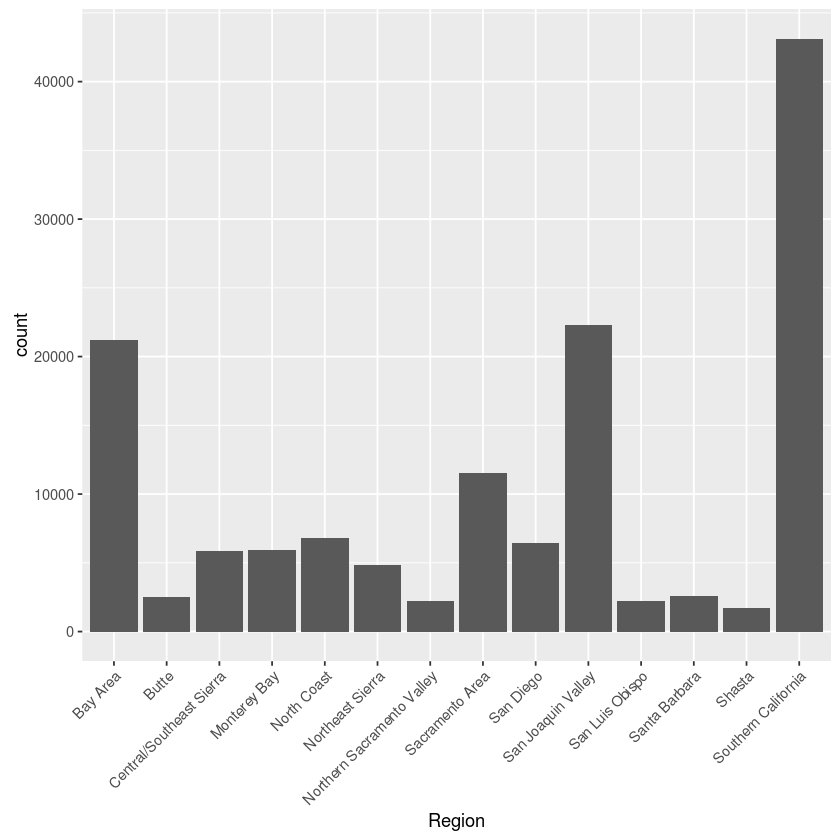

In [17]:
c + geom_bar() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + xlab("Region")

Güney Kaliforniya en çok yaralanmanın olduğu bölge olarak dikkat çekiyor.

Burada grafiklerde dikkat edilmesi gereken önemli durum, verinin Spark tarafında DataFrame lerde filtreleme, gruplama vb işlemlerden sonra ggplot ile grafiğin çizilmesidir. Yoksa performans problemleri yaşamamız olasıdır.

## Veri seçme işlemi
SparkSQL ile *select* işlemi iki türlü yapılabilir. Birincisi select ile kolon isimleri kullanımı iledir. İkincisi ise selectExpr kullanarak daha karmaşık hesaplamalar içindir.

In [18]:
?select

$                    package:SparkR                    R Documentation

_S_e_l_e_c_t

_D_e_s_c_r_i_p_t_i_o_n:

     Selects a set of columns with names or Column expressions.

_U_s_a_g_e:

     ## S4 method for signature 'DataFrame'
     x$name
     
     ## S4 replacement method for signature 'DataFrame'
     x$name <- value
     
     ## S4 method for signature 'DataFrame,character'
     select(x, col, ...)
     
     ## S4 method for signature 'DataFrame,Column'
     select(x, col, ...)
     
     ## S4 method for signature 'DataFrame,list'
     select(x, col)
     
     select(x, col, ...)
     
     selectExpr(x, expr, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: A DataFrame

     col: A list of columns or single Column or name

_V_a_l_u_e:

     A new DataFrame with selected columns

_S_e_e _A_l_s_o:

     Other DataFrame functions: ‘DataFrame-class’, ‘dataFrame’,
     ‘groupedData’; ‘[’, ‘[’, ‘[[’, ‘subset’; ‘agg’, ‘agg’,
     ‘count,GroupedData-method’, ‘summarize’, ‘summarize’; ‘arrange’,
     ‘arrange’, ‘arrange’, ‘orderBy’, ‘orderBy’; ‘as.data.frame’,
     ‘as.data.frame,DataFrame-method’; ‘attach’,
     ‘attach,DataFrame-method’; ‘cache’; ‘collect’; ‘colnames’,
     ‘colnames’, ‘colnames<-’, ‘colnames<-’, ‘columns’, ‘names’,
     ‘names<-’; ‘coltypes’, ‘coltypes’, ‘coltypes<-’, ‘coltypes<-’;
     ‘columns’, ‘dtypes’, ‘printSchema’, ‘schema’, ‘schema’; ‘count’,
     ‘nrow’; ‘describe’, ‘describe’, ‘describe’, ‘summary’, ‘summary’,
     ‘summary,PipelineModel-method’; ‘dim’; ‘distinct’, ‘unique’;
     ‘dropna’, ‘dropna’, ‘fillna’, ‘fillna’, ‘na.omit’, ‘na.omit’;
     ‘dtypes’; ‘except’, ‘except’; ‘explain’, ‘explain’; ‘filter’,
     ‘filter’, ‘where’, ‘where’; ‘first’, ‘first’; ‘groupBy’,
     ‘groupBy’, ‘group_by’, ‘group_by’; ‘head’; ‘insertInto’,
     ‘insertInto’; ‘intersect’, ‘intersect’; ‘isLocal’, ‘isLocal’;
     ‘join’; ‘limit’, ‘limit’; ‘merge’, ‘merge’; ‘mutate’, ‘mutate’,
     ‘transform’; ‘ncol’; ‘persist’; ‘printSchema’; ‘rbind’, ‘rbind’,
     ‘unionAll’, ‘unionAll’; ‘registerTempTable’, ‘registerTempTable’;
     ‘rename’, ‘rename’, ‘withColumnRenamed’, ‘withColumnRenamed’;
     ‘repartition’; ‘sample’, ‘sample’, ‘sample_frac’, ‘sample_frac’;
     ‘saveAsParquetFile’, ‘saveAsParquetFile’, ‘write.parquet’,
     ‘write.parquet’; ‘saveAsTable’, ‘saveAsTable’; ‘saveDF’, ‘saveDF’,
     ‘write.df’, ‘write.df’; ‘selectExpr’; ‘showDF’, ‘showDF’; ‘show’,
     ‘show’, ‘show,GroupedData-method’; ‘take’; ‘transform’,
     ‘withColumn’, ‘withColumn’; ‘unpersist’; ‘write.json’,
     ‘write.json’

     Other DataFrame functions: ‘DataFrame-class’, ‘dataFrame’,
     ‘groupedData’; ‘[’, ‘[’, ‘[[’, ‘subset’; ‘agg’, ‘agg’,
     ‘count,GroupedData-method’, ‘summarize’, ‘summarize’; ‘arrange’,
     ‘arrange’, ‘arrange’, ‘orderBy’, ‘orderBy’; ‘as.data.frame’,
     ‘as.data.frame,DataFrame-method’; ‘attach’,
     ‘attach,DataFrame-method’; ‘cache’; ‘collect’; ‘colnames’,
     ‘colnames’, ‘colnames<-’, ‘colnames<-’, ‘columns’, ‘names’,
     ‘names<-’; ‘coltypes’, ‘coltypes’, ‘coltypes<-’, ‘coltypes<-’;
     ‘columns’, ‘dtypes’, ‘printSchema’, ‘schema’, ‘schema’; ‘count’,
     ‘nrow’; ‘describe’, ‘describe’, ‘describe’, ‘summary’, ‘summary’,
     ‘summary,PipelineModel-method’; ‘dim’; ‘distinct’, ‘unique’;
     ‘dropna’, ‘dropna’, ‘fillna’, ‘fillna’, ‘na.omit’, ‘na.omit’;
     ‘dtypes’; ‘except’, ‘except’; ‘explain’, ‘explain’; ‘filter’,
     ‘filter’, ‘where’, ‘where’; ‘first’, ‘first’; ‘groupBy’,
     ‘groupBy’, ‘group_by’, ‘group_by’; ‘head’; ‘insertInto’,
     ‘insertInto’; ‘intersect’, ‘intersect’; ‘isLocal’, ‘isLocal’;
     ‘join’; ‘limit’, ‘limit’; ‘merge’, ‘merge’; ‘mutate’, ‘mutate’,
     ‘transform’; ‘ncol’; ‘persist’; ‘printSchema’; ‘rbind’, ‘rbind’,
     ‘unionAll’, ‘unionAll’; ‘registerTempTable’, ‘registerTempTable’;
     ‘rename’, ‘rename’, ‘withColumnRenamed’, ‘withColumnRenamed’;
     ‘repartition’; ‘sample’, ‘sample’, ‘sample_frac’, ‘sample_frac’;
     ‘saveAsParquetFile’

R kullanıcıları veri ile analiz yaparken SQL yerine [dplyr](https://cran.r-project.org/web/packages/dplyr/vignettes/introduction.html) paketini kullanırlar. Buna benzer olarak SparkR da veriden iki kolonu getirmek istediğimizde şöyle yaparız. 

In [19]:
collect(select(traffic_injuries_df, "region_name", "injuries"))

region_name     injuries
1                                 4.089000e+03
2                                 1.344300e+04
3                                 8.500000e+01
4                                 5.500000e+02
5                                 9.000000e+00
6                                 2.200000e+01
7                                 3.178000e+03
8                                 9.665000e+03
9                                 3.180000e+02
10                                1.563000e+03
11                                4.300000e+02
12                                1.482000e+03
13                                6.900000e+01
14                                1.610000e+02
15                                3.574000e+03
16                                1.141100e+04
17                                4.136000e+03
18                                1.335433e+04
19                                1.050000e+02
20                                6.490000e+02
21                                6.666667e+00
22                                3.000000e+01
23                                3.041000e+03
24                                9.274333e+03
25                                3.453333e+02
26                                1.641667e+03
27                                5.793333e+02
28                                1.600667e+03
29                                5.866667e+01
30                                1.586667e+02
31                                3.451667e+03
32                                1.110467e+04
33                                4.225000e+03
34                                1.304200e+04
35                                1.080000e+02
36                                6.350000e+02
37                                7.000000e+00
38                                4.200000e+01
39                                3.057000e+03
40                                8.984000e+03
41                                3.680000e+02
42                                1.654000e+03
43                                6.330000e+02
44                                1.580000e+03
45                                5.200000e+01
46                                1.470000e+02
47                                3.484000e+03
48                                1.082700e+04
49                                4.094000e+03
50                                1.357800e+04
51                                1.220000e+02
52                                7.620000e+02
53                                4.000000e+00
54                                2.600000e+01
55                                2.888000e+03
56                                9.174000e+03
57                                3.500000e+02
58                                1.708000e+03
59                                6.750000e+02
60                                1.740000e+03
61                                5.500000e+01
62                                1.680000e+02
63                                3.297000e+03
64                                1.107600e+04
65                                4.304000e+03
66                                1.316400e+04
67                                1.290000e+02
68                                7.480000e+02
69                                1.300000e+01
70                                2.900000e+01
71                                2.972000e+03
72                                8.750000e+03
73                                4.040000e+02
74                                1.704000e+03
75                                7.380000e+02
76                                1.767000e+03
77                                4.800000e+01
78                                1.660000e+02
79                                3.437000e+03
80                                1.064900e+04
81                                4.156000e+03
82                                1.312867e+04
83                                1.356667e+02
84                                7.610000e+02
85                         

[dplyr](https://cran.r-project.org/web/packages/dplyr/vignettes/introduction.html) paketi kullanılmadığında R ile yukarıdaki sorgu şöyle yazılabilir.

In [20]:
collect(traffic_injuries_df[,c("region_name", "injuries")])

region_name     injuries
1                                 4.089000e+03
2                                 1.344300e+04
3                                 8.500000e+01
4                                 5.500000e+02
5                                 9.000000e+00
6                                 2.200000e+01
7                                 3.178000e+03
8                                 9.665000e+03
9                                 3.180000e+02
10                                1.563000e+03
11                                4.300000e+02
12                                1.482000e+03
13                                6.900000e+01
14                                1.610000e+02
15                                3.574000e+03
16                                1.141100e+04
17                                4.136000e+03
18                                1.335433e+04
19                                1.050000e+02
20                                6.490000e+02
21                                6.666667e+00
22                                3.000000e+01
23                                3.041000e+03
24                                9.274333e+03
25                                3.453333e+02
26                                1.641667e+03
27                                5.793333e+02
28                                1.600667e+03
29                                5.866667e+01
30                                1.586667e+02
31                                3.451667e+03
32                                1.110467e+04
33                                4.225000e+03
34                                1.304200e+04
35                                1.080000e+02
36                                6.350000e+02
37                                7.000000e+00
38                                4.200000e+01
39                                3.057000e+03
40                                8.984000e+03
41                                3.680000e+02
42                                1.654000e+03
43                                6.330000e+02
44                                1.580000e+03
45                                5.200000e+01
46                                1.470000e+02
47                                3.484000e+03
48                                1.082700e+04
49                                4.094000e+03
50                                1.357800e+04
51                                1.220000e+02
52                                7.620000e+02
53                                4.000000e+00
54                                2.600000e+01
55                                2.888000e+03
56                                9.174000e+03
57                                3.500000e+02
58                                1.708000e+03
59                                6.750000e+02
60                                1.740000e+03
61                                5.500000e+01
62                                1.680000e+02
63                                3.297000e+03
64                                1.107600e+04
65                                4.304000e+03
66                                1.316400e+04
67                                1.290000e+02
68                                7.480000e+02
69                                1.300000e+01
70                                2.900000e+01
71                                2.972000e+03
72                                8.750000e+03
73                                4.040000e+02
74                                1.704000e+03
75                                7.380000e+02
76                                1.767000e+03
77                                4.800000e+01
78                                1.660000e+02
79                                3.437000e+03
80                                1.064900e+04
81                                4.156000e+03
82                                1.312867e+04
83                                1.356667e+02
84                                7.610000e+02
85                         

region_name de hangi değerlerin tekil olarak bulunduğunu dplyr de ve benzer olarak SparkR de şöyle buluruz.

In [21]:
collect(distinct(select(traffic_injuries_df, "region_name")))

region_name
1                 North Coast
2                      Shasta
3          San Joaquin Valley
4                Monterey Bay
5             Sacramento Area
6                       Butte
7            Northeast Sierra
8                    Bay Area
9  Northern Sacramento Valley
10              Santa Barbara
11                  San Diego
12   Central/Southeast Sierra
13        Southern California
14            San Luis Obispo
15

SelectExpr ile ilgili bir örnek ise şöyle verilebilir. Toplam nüfusa göre yaralanma oranını 100.000 de kaç olduğunu şöyle bulabiliriz.

In [25]:
head(collect(selectExpr(traffic_injuries_df, "injuries","totalpop", "100000*injuries/totalpop as Yuzbinde")))

injuries totalpop    Yuzbinde
1     4089 34944563 11.70139114
2    13443 34944563 38.46950383
3       85 33493644  0.25377950
4      550 33493644  1.64210262
5        9 34944563  0.02575508
6       22 34944563  0.06295686

## filtreleme, alt küme ve SQL
Yukarıda kolonları seçerken *select* i kullandık. Satırları seçerken *filter* ve *contains* kullanabiliriz.

In [26]:
?filter

filter                 package:SparkR                  R Documentation

_F_i_l_t_e_r

_D_e_s_c_r_i_p_t_i_o_n:

     Filter the rows of a DataFrame according to a given condition.

_U_s_a_g_e:

     ## S4 method for signature 'DataFrame,characterOrColumn'
     filter(x, condition)
     
     ## S4 method for signature 'DataFrame,characterOrColumn'
     where(x, condition)
     
     filter(x, condition)
     
     where(x, condition)
     
_A_r_g_u_m_e_n_t_s:

       x: A DataFrame to be sorted.

condition: The condition to filter on. This may either be a Column
          expression or a string containing a SQL statement

_V_a_l_u_e:

     A DataFrame containing only the rows that meet the condition.

_S_e_e _A_l_s_o:

     Other DataFrame functions: ‘$’, ‘$<-’, ‘select’, ‘select’,
     ‘select,DataFrame,Column-method’, ‘select,DataFrame,list-method’,
     ‘selectExpr’; ‘DataFrame-class’, ‘dataFrame’, ‘groupedData’; ‘[’,
     ‘[’, ‘[[’, ‘subset’; ‘agg’, ‘agg’, ‘count,GroupedData-method’,
     ‘summarize’, ‘summarize’; ‘arrange’, ‘arrange’, ‘arrange’,
     ‘orderBy’, ‘orderBy’; ‘as.data.frame’,
     ‘as.data.frame,DataFrame-method’; ‘attach’,
     ‘attach,DataFrame-method’; ‘cache’; ‘collect’; ‘colnames’,
     ‘colnames’, ‘colnames<-’, ‘colnames<-’, ‘columns’, ‘names’,
     ‘names<-’; ‘coltypes’, ‘coltypes’, ‘coltypes<-’, ‘coltypes<-’;
     ‘columns’, ‘dtypes’, ‘printSchema’, ‘schema’, ‘schema’; ‘count’,
     ‘nrow’; ‘describe’, ‘describe’, ‘describe’, ‘summary’, ‘summary’,
     ‘summary,PipelineModel-method’; ‘dim’; ‘distinct’, ‘unique’;
     ‘dropna’, ‘dropna’, ‘fillna’, ‘fillna’, ‘na.omit’, ‘na.omit’;
     ‘dtypes’; ‘except’, ‘except’; ‘explain’, ‘explain’; ‘first’,
     ‘first’; ‘groupBy’, ‘groupBy’, ‘group_by’, ‘group_by’; ‘head’;
     ‘insertInto’, ‘insertInto’; ‘intersect’, ‘intersect’; ‘isLocal’,
     ‘isLocal’; ‘join’; ‘limit’, ‘limit’; ‘merge’, ‘merge’; ‘mutate’,
     ‘mutate’, ‘transform’; ‘ncol’; ‘persist’; ‘printSchema’; ‘rbind’,
     ‘rbind’, ‘unionAll’, ‘unionAll’; ‘registerTempTable’,
     ‘registerTempTable’; ‘rename’, ‘rename’, ‘withColumnRenamed’,
     ‘withColumnRenamed’; ‘repartition’; ‘sample’, ‘sample’,
     ‘sample_frac’, ‘sample_frac’; ‘saveAsParquetFile’,
     ‘saveAsParquetFile’, ‘write.parquet’, ‘write.parquet’;
     ‘saveAsTable’, ‘saveAsTable’; ‘saveDF’, ‘saveDF’, ‘write.df’,
     ‘write.df’; ‘selectExpr’; ‘showDF’, ‘showDF’; ‘show’, ‘show’,
     ‘show,GroupedData-method’; ‘take’; ‘transform’, ‘withColumn’,
     ‘withColumn’; ‘unpersist’; ‘write.json’, ‘write.json’

     Other DataFrame functions: ‘$’, ‘$<-’, ‘select’, ‘select’,
     ‘select,DataFrame,Column-method’, ‘select,DataFrame,list-method’,
     ‘selectExpr’; ‘DataFrame-class’, ‘dataFrame’, ‘groupedData’; ‘[’,
     ‘[’, ‘[[’, ‘subset’; ‘agg’, ‘agg’, ‘count,GroupedData-method’,
     ‘summarize’, ‘summarize’; ‘arrange’, ‘arrange’, ‘arrange’,
     ‘orderBy’, ‘orderBy’; ‘as.data.frame’,
     ‘as.data.frame,DataFrame-method’; ‘attach’,
     ‘attach,DataFrame-method’; ‘cache’; ‘collect’; ‘colnames’,
     ‘colnames’, ‘colnames<-’, ‘colnames<-’, ‘columns’, ‘names’,
     ‘names<-’; ‘coltypes’, ‘coltypes’, ‘coltypes<-’, ‘coltypes<-’;
     ‘columns’, ‘dtypes’, ‘printSchema’, ‘schema’, ‘schema’; ‘count’,
     ‘nrow’; ‘describe’, ‘describe’, ‘describe’, ‘summary’, ‘summary’,
     ‘summary,PipelineModel-method’; ‘dim’; ‘distinct’, ‘unique’;
     ‘dropna’, ‘dropna’, ‘fillna’, ‘fillna’, ‘na.omit’, ‘na.omit’;
     ‘dtypes’; ‘except’, ‘except’; ‘explain’, ‘explain’; ‘first’,
     ‘first’; ‘groupBy’, ‘groupBy’, ‘group_by’, ‘group_by’; ‘head’;
     ‘insertInto’, ‘insertInto’; ‘intersect’, ‘intersect’; ‘isLocal’,
     ‘isLocal’; ‘join’; ‘limit’, ‘limit’; ‘merge’, ‘merge’; ‘mutate’,
     ‘mutate’, ‘transform’; ‘ncol’; ‘persist’; ‘printSchema’; ‘rbind’,
     ‘rbind’, ‘unionAll’, ‘unionAll’; ‘registerTempTable’,
     ‘registerTempTable’; ‘rename’, ‘rename’, ‘withColumnRenamed’,
     ‘withColumnRenamed’; ‘repartition’; ‘sam

*filter* komutunu kullanarak koşul verebiliriz. Örnek olarak 10.000 den çok yaralanma olan kayıtları getirelim.

In [27]:
system.time(
    traffic_injuries_df_10000 <- collect(filter(select(traffic_injuries_df, "region_name", "injuries"), "injuries > 10000"))
)
traffic_injuries_df_10000

   user  system elapsed 
  0.016   0.004  13.557 

region_name injuries
1              13443.00
2              11411.00
3              13354.33
4              11104.67
5              13042.00
6              10827.00
7              13578.00
8              11076.00
9              13164.00
10             10649.00
11             13128.67
12             10595.00
13             13089.00
14             10589.00
15             11903.80
16             13133.00
17             10547.00
18             11943.00
19             11099.00
20             10931.00
21             10423.00

Aynı sorguyu SparkSQL de SQL sorgusu kullanarak da yapabiliriz. Önce tabloyu *register* etmemiz gerekiyor.

In [28]:
registerTempTable(traffic_injuries_df, "traffic_injuries_table")

SparkR ın *sql* fonksiyonunu sqlContext ile kullanarak SQL sorgulamasını şöyle yaparız.

In [29]:
system.time(
    traffic_injuries_df_10000_sql <- collect(sql(sqlContext, "SELECT region_name, injuries FROM traffic_injuries_table WHERE injuries > 10000"))
)

   user  system elapsed 
  0.016   0.000  14.538 

In [30]:
head(traffic_injuries_df_10000_sql)

region_name injuries
1             13443.00
2             11411.00
3             13354.33
4             11104.67
5             13042.00
6             10827.00

SQL e alışık kullanıcılar için bu şekilde SparkSQL kullanımı daha kolay oluyor. Ama R dilinde uzman olanlar için *subset* komutu daha kullanışlı olabilir.

In [31]:
?subset

[[                   package:SparkR                    R Documentation

_S_u_b_s_e_t

_D_e_s_c_r_i_p_t_i_o_n:

     Return subsets of DataFrame according to given conditions

_U_s_a_g_e:

     ## S4 method for signature 'DataFrame,numericOrcharacter'
     x[[i]]
     
     ## S4 method for signature 'DataFrame,missing'
     x[i, j, ..., drop = TRUE]
     
     ## S4 method for signature 'DataFrame,Column'
     x[i, j, ..., drop = TRUE]
     
     ## S4 method for signature 'DataFrame'
     subset(x, subset, select, ...)
     
_A_r_g_u_m_e_n_t_s:

       x: A DataFrame

  subset: (Optional) A logical expression to filter on rows

  select: expression for the single Column or a list of columns to
          select from the DataFrame

_V_a_l_u_e:

     A new DataFrame containing only the rows that meet the condition
     with selected columns

_S_e_e _A_l_s_o:

     Other DataFrame functions: ‘$’, ‘$<-’, ‘select’, ‘select’,
     ‘select,DataFrame,Column-method’, ‘select,DataFrame,list-method’,
     ‘selectExpr’; ‘DataFrame-class’, ‘dataFrame’, ‘groupedData’;
     ‘agg’, ‘agg’, ‘count,GroupedData-method’, ‘summarize’,
     ‘summarize’; ‘arrange’, ‘arrange’, ‘arrange’, ‘orderBy’,
     ‘orderBy’; ‘as.data.frame’, ‘as.data.frame,DataFrame-method’;
     ‘attach’, ‘attach,DataFrame-method’; ‘cache’; ‘collect’;
     ‘colnames’, ‘colnames’, ‘colnames<-’, ‘colnames<-’, ‘columns’,
     ‘names’, ‘names<-’; ‘coltypes’, ‘coltypes’, ‘coltypes<-’,
     ‘coltypes<-’; ‘columns’, ‘dtypes’, ‘printSchema’, ‘schema’,
     ‘schema’; ‘count’, ‘nrow’; ‘describe’, ‘describe’, ‘describe’,
     ‘summary’, ‘summary’, ‘summary,PipelineModel-method’; ‘dim’;
     ‘distinct’, ‘unique’; ‘dropna’, ‘dropna’, ‘fillna’, ‘fillna’,
     ‘na.omit’, ‘na.omit’; ‘dtypes’; ‘except’, ‘except’; ‘explain’,
     ‘explain’; ‘filter’, ‘filter’, ‘where’, ‘where’; ‘first’, ‘first’;
     ‘groupBy’, ‘groupBy’, ‘group_by’, ‘group_by’; ‘head’;
     ‘insertInto’, ‘insertInto’; ‘intersect’, ‘intersect’; ‘isLocal’,
     ‘isLocal’; ‘join’; ‘limit’, ‘limit’; ‘merge’, ‘merge’; ‘mutate’,
     ‘mutate’, ‘transform’; ‘ncol’; ‘persist’; ‘printSchema’; ‘rbind’,
     ‘rbind’, ‘unionAll’, ‘unionAll’; ‘registerTempTable’,
     ‘registerTempTable’; ‘rename’, ‘rename’, ‘withColumnRenamed’,
     ‘withColumnRenamed’; ‘repartition’; ‘sample’, ‘sample’,
     ‘sample_frac’, ‘sample_frac’; ‘saveAsParquetFile’,
     ‘saveAsParquetFile’, ‘write.parquet’, ‘write.parquet’;
     ‘saveAsTable’, ‘saveAsTable’; ‘saveDF’, ‘saveDF’, ‘write.df’,
     ‘write.df’; ‘selectExpr’; ‘showDF’, ‘showDF’; ‘show’, ‘show’,
     ‘show,GroupedData-method’; ‘take’; ‘transform’, ‘withColumn’,
     ‘withColumn’; ‘unpersist’; ‘write.json’, ‘write.json’

     Other subsetting functions: ‘$’, ‘$<-’, ‘select’, ‘select’,
     ‘select,DataFrame,Column-method’, ‘select,DataFrame,list-method’,
     ‘selectExpr’; ‘filter’, ‘filter’, ‘where’, ‘where’

_E_x_a_m_p_l_e_s:

     ## Not run:
     
       # Columns can be selected using `[[` and `[`
       df[[2]] == df[["age"]]
       df[,2] == df[,"age"]
       df[,c("name", "age")]
       # Or to filter rows
       df[df$age > 20,]
       # DataFrame can be subset on both rows and Columns
       df[df$name == "Smith", c(1,2)]
       df[df$age %in% c(19, 30), 1:2]
       subset(df, df$age %in% c(19, 30), 1:2)
       subset(df, df$age %in% c(19), select = c(1,2))
       subset(df, select = c(1,2))
     ## End(Not run)

Bir önceki sorgu şu şekilde yapılabilir.

In [33]:
system.time(
    traffic_injuries_df_10000_subset <- collect(subset(traffic_injuries_df, traffic_injuries_df$injuries>10000, c("region_name","injuries")))
)
head(traffic_injuries_df_10000_subset)

   user  system elapsed 
  0.024   0.004  13.679 

region_name injuries
1             13443.00
2             11411.00
3             13354.33
4             11104.67
5             13042.00
6             10827.00

In [ ]:
İstenirse pure R komutları ile şöyle de yapılabilir.

In [38]:
system.time(
    traffic_injuries_df_10000_R <- collect(traffic_injuries_df[traffic_injuries_df$injuries>1000, c("region_name","injuries")])
)
head(traffic_injuries_df_10000_R)

   user  system elapsed 
  0.044   0.012  12.707 

region_name injuries
1                 4089
2                13443
3                 3178
4                 9665
5                 1563
6                 1482

SparkR da bir veri setinin alt kümesini almak için dört ayrı yöntem kullanmış olduk.
1. filter(select kullanarak
2. sqlContext ile SQL sorgusu kullanarak
3. subset komutu ile
4. sadece temel R kullanarak

Bu dört yöntem ile çıkan sonuçların her birini *ggplot* kullanarak grafik olarak gösterebilirim. Pratik olması açısından sondakini gösterelim.

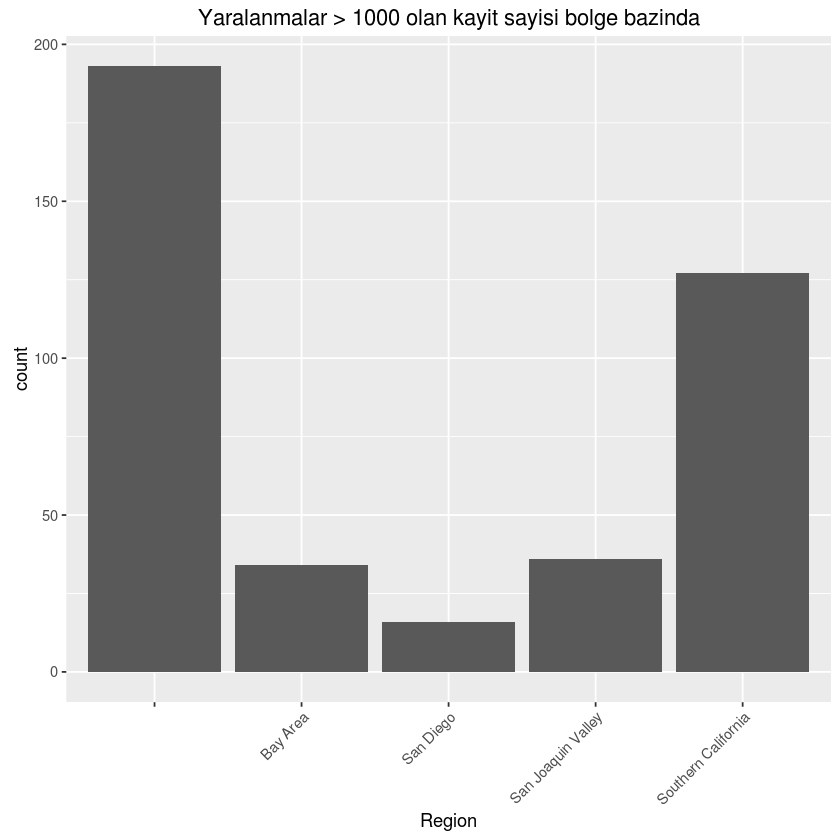

In [50]:
c <- ggplot(data=traffic_injuries_df_10000_R, aes(x=factor(region_name)))
c + geom_bar() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    ggtitle("Yaralanmalar > 1000 olan kayit sayisi bolge bazinda") + xlab("Region")

DataFrame lerde özellikle null olan değerler için kullanılan [is.nan](https://spark.apache.org/docs/latest/api/R/is.nan.html) fonksiyonu da SparkR da vardır ve gerektiğinde kullanılabilir.

## Veri toparlama ve sıralama
DataFrame üzerinde veri karakteristiklerini anlamada ve kullanmada sılça kullandığımız bazı fonksiyonlar SparkR da kullanımımıza sunulmuştur. R daki bazı fonksiyonlar eksik olsada var olanlar ile pek çok işlem yapabiliriz. Örnek olarak şu altı fonksiyon verilebilir.


- [avg](https://spark.apache.org/docs/latest/api/R/avg.html)
- [min](https://spark.apache.org/docs/latest/api/R/min.html)
- [max](https://spark.apache.org/docs/latest/api/R/max.html)
- [sum](https://spark.apache.org/docs/latest/api/R/sum.html)
- [countDistinct](https://spark.apache.org/docs/latest/api/R/countDistinct.html)
- [sumDistinct](https://spark.apache.org/docs/latest/api/R/sumDistinct.html)

ve daha başkalarıda var. Bunların tam listesine [buradan](https://spark.apache.org/docs/latest/api/R/) bakabilirsiniz.

In [57]:
collect(select(traffic_injuries_df, 
  min(traffic_injuries_df$injuries), 
  max(traffic_injuries_df$injuries), 
  avg(traffic_injuries_df$injuries)
))

min(injuries) max(injuries) avg(injuries)
1           0.2         13578      7.278505

## Grouplama
Yukarıdaki hesaplamayı bölge bazında yapmak isteyebiliriz. Bu durumda *groupBy* ve *agg* komutlarını kullanıyoruz.

In [59]:
traffic_injuries_df_stats_region <- collect(agg(
  groupBy(traffic_injuries_df, "region_name"),
  NumOfInjuries = n(traffic_injuries_df$injuries),
  MinInjuries = min(traffic_injuries_df$injuries), 
  MaxInjuries = max(traffic_injuries_df$injuries), 
  AvgInjuries = avg(traffic_injuries_df$injuries)
))
traffic_injuries_df_stats_region

region_name NumOfInjuries MinInjuries MaxInjuries AvgInjuries
1                 North Coast          6689         0.2         291    6.100154
2                      Shasta          1713         0.2         116    9.255108
3          San Joaquin Valley         22166         0.2        1866   13.270480
4                Monterey Bay          5909         0.2         390    8.581159
5             Sacramento Area         11473         0.2         996   12.661013
6                       Butte          2463         0.2         160    7.652808
7            Northeast Sierra          4706         0.2         216    5.306871
8                    Bay Area         21126         0.2        2053   14.941658
9  Northern Sacramento Valley          2180         0.2         120    6.938379
10              Santa Barbara          2565         0.2         215   11.099155
11                  San Diego          6445         0.2        1076   25.977657
12   Central/Southeast Sierra          5835         0.2         239    5.595544
13        Southern California         42998         0.2        6006   22.610480
14            San Luis Obispo          2237         0.2         150    8.602503
15                                   354338         0.2       13578    4.080234

İstediğimiz kadar alt gruplama yapabiliriz.

In [61]:
traffic_injuries_df_stats_region <- collect(agg(
  groupBy(traffic_injuries_df, "region_name", "county_name"),
  NumOfInjuries = n(traffic_injuries_df$injuries),
  MinInjuries = min(traffic_injuries_df$injuries), 
  MaxInjuries = max(traffic_injuries_df$injuries), 
  AvgInjuries = avg(traffic_injuries_df$injuries)
))
traffic_injuries_df_stats_region

region_name     county_name NumOfInjuries MinInjuries
1             Northeast Sierra          Plumas          1115   0.2000000
2                                San Francisco          6777   0.2000000
3                 Monterey Bay      San Benito           608   0.2000000
4                                        Marin          2120   0.2000000
5           San Joaquin Valley          Merced          2141   0.2000000
6                                       Solano          3938   0.2000000
7           San Joaquin Valley     San Joaquin          3003   0.2000000
8                                       Lassen           555   0.2000000
9                 Monterey Bay                           186   0.3333333
10         Southern California          Orange          5631   0.2000000
11                 North Coast       Mendocino          1646   0.2000000
12    Central/Southeast Sierra          Amador          1067   0.2000000
13                                    Tuolumne           784   0.2000000
14                                Contra Costa          8352   0.2000000
15                                  Sacramento         14609   0.2000000
16             Sacramento Area                           199   0.3333333
17                                      Nevada          1220   0.2000000
18                      Shasta          Shasta          1543   0.2000000
19          San Joaquin Valley                           199   0.6666667
20                                      Madera          1659   0.2000000
21         Southern California        Imperial          1628   0.2000000
22                 North Coast                           171   0.2000000
23         Southern California         Ventura          3276   0.2000000
24                                   Calaveras           706   0.2000000
25                    Bay Area     Santa Clara          2987   0.2000000
26                                      Plumas           460   0.2000000
27                                        Kern          7925   0.2000000
28                                       Glenn           429   0.2000000
29                    Bay Area       San Mateo          2728   0.2000000
30                                      Sutter          1093   0.2000000
31    Central/Southeast Sierra                           177   0.2000000
32                                   Del Norte           432   0.2000000
33                                    Imperial          1640   0.2000000
34                   San Diego       San Diego          6249   0.2000000
35                               Santa Barbara          4414   0.2000000
36          San Joaquin Valley      Stanislaus          2811   0.2000000
37                                   San Diego         27837   0.2000000
38                    Bay Area         Alameda          3203   0.2000000
39            Northeast Sierra                           182   0.2000000
40  Northern Sacramento Valley           Glenn           537   0.2000000
41         Southern California     Los Angeles         16663   0.2000000
42               Santa Barbara   Santa Barbara          2386   0.2000000
43                                      Amador           697   0.2000000
44    Central/Southeast Sierra            Mono           566   0.2000000
45                                  Santa Cruz          2775   0.2000000
46                                      Merced          2757   0.2000000
47                       Butte                           166   0.2000000
48             Sacramento Area          Placer          2113   0.2000000
49                                 San Joaquin          6973   0.2000000
50                                   Mendocino          1355   0.2000000
51             Sacramento Area            Yolo          1388   0.2000000
52                    Bay Area          Sonoma          2708   0.2000000
53                                    Monterey          3909   0.2000000
54             San Luis Obispo San Luis Obispo          2074   0.2000000
55  

## Sıralama
Sıralama için *arrange* kullanılır. Bir önceki sorguda çıkan sonucu istediğimiz kolon(lar)a göre sıralayalım. Örnek olarak *region_name* ve *county_name* e göre sıralayalım.

In [71]:
traffic_injuries_df_stats_region <- agg(
  groupBy(traffic_injuries_df, "region_name", "county_name"),
  NumOfInjuries = n(traffic_injuries_df$injuries),
  MinInjuries = min(traffic_injuries_df$injuries), 
  MaxInjuries = max(traffic_injuries_df$injuries), 
  AvgInjuries = avg(traffic_injuries_df$injuries)
)
traffic_injuries_df_stats_region_sorted <- collect(arrange(traffic_injuries_df_stats_region, 
                                                         desc(traffic_injuries_df_stats_region$region_name), 
                                                         desc(traffic_injuries_df_stats_region$county_name )))
traffic_injuries_df_stats_region_sorted

region_name     county_name NumOfInjuries MinInjuries
1          Southern California         Ventura          3276   0.2000000
2          Southern California  San Bernardino          6459   0.2000000
3          Southern California       Riverside          9134   0.2000000
4          Southern California          Orange          5631   0.2000000
5          Southern California     Los Angeles         16663   0.2000000
6          Southern California        Imperial          1628   0.2000000
7          Southern California                           207   1.0000000
8                       Shasta          Shasta          1543   0.2000000
9                       Shasta                           170   0.2000000
10               Santa Barbara   Santa Barbara          2386   0.2000000
11               Santa Barbara                           179   0.3333333
12             San Luis Obispo San Luis Obispo          2074   0.2000000
13             San Luis Obispo                           163   0.2000000
14          San Joaquin Valley          Tulare          3142   0.2000000
15          San Joaquin Valley      Stanislaus          2811   0.2000000
16          San Joaquin Valley     San Joaquin          3003   0.2000000
17          San Joaquin Valley          Merced          2141   0.2000000
18          San Joaquin Valley          Madera          1439   0.2000000
19          San Joaquin Valley           Kings          1307   0.2000000
20          San Joaquin Valley            Kern          4114   0.2000000
21          San Joaquin Valley          Fresno          4010   0.2000000
22          San Joaquin Valley                           199   0.6666667
23                   San Diego       San Diego          6249   0.2000000
24                   San Diego                           196   0.2000000
25             Sacramento Area            Yuba          1290   0.2000000
26             Sacramento Area            Yolo          1388   0.2000000
27             Sacramento Area          Sutter          1059   0.2000000
28             Sacramento Area      Sacramento          3864   0.2000000
29             Sacramento Area          Placer          2113   0.2000000
30             Sacramento Area       El Dorado          1560   0.2000000
31             Sacramento Area                           199   0.3333333
32  Northern Sacramento Valley          Tehama           895   0.2000000
33  Northern Sacramento Valley           Glenn           537   0.2000000
34  Northern Sacramento Valley          Colusa           571   0.2000000
35  Northern Sacramento Valley                           177   0.2000000
36            Northeast Sierra        Siskiyou          1205   0.2000000
37            Northeast Sierra          Sierra           285   0.2000000
38            Northeast Sierra          Plumas          1115   0.2000000
39            Northeast Sierra          Nevada           837   0.2000000
40            Northeast Sierra           Modoc           389   0.2000000
41            Northeast Sierra          Lassen           693   0.2000000
42            Northeast Sierra                           182   0.2000000
43                 North Coast         Trinity           824   0.2000000
44                 North Coast       Mendocino          1646   0.2000000
45                 North Coast            Lake          1594   0.2000000
46                 North Coast        Humboldt          1817   0.2000000
47                 North Coast       Del Norte           637   0.2000000
48                 North Coast                           171   0.2000000
49                Monterey Bay      Santa Cruz          2401   0.2000000
50                Monterey Bay      San Benito           608   0.2000000
51                Monterey Bay        Monterey          2714   0.2000000
52                Monterey Bay                           186   0.3333333
53    Central/Southeast Sierra        Tuolumne          1119   0.2000000
54    Central/Southeast Sierra            Mono           566   0.2000000
55  

Bu kadar. Bir sonraki notebook da, burada öğrendiğimiz fonksiyonlar ve ggplot yardımı ile veriyi keşfedeceğiz.